In [1]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [3]:
# Подготовка данных к анализу

GVK = pd.read_excel('Медвежье НГКМ_ГВК_тек.xlsx')
Wells = pd.read_excel('Медвежье НГКМ_ГВК_нач.xlsx')
Production = pd.read_excel('Медвежье НГКМ_Добыча_по_УКПГ.xlsx')
Perforations = pd.read_excel('Медвежье НГКМ_Перфорация.xlsx')
Pressure = pd.read_excel('Медвежье НГКМ_Пластовые_давления.xlsx')
Intervals = pd.read_excel('Медвежье НГКМ_Работающие_интервалы.xlsx')

In [4]:
# Создадим словарь с названиями УКПГ для каждой скважины
UKPG_codes = Perforations[['Скважина', 'Участок']].fillna(0).drop_duplicates().set_index('Скважина')['Участок'].to_dict()

# Добавим в столбец Участок название УКПГ
GVK['Участок'] = GVK['Скважина'].map(UKPG_codes)
Pressure['Участок'] = Pressure['Скважина'].map(UKPG_codes)

# Добавим столбцы Год в датасеты
Pressure['Год'] = Pressure['Дата'].dt.year
GVK['Год'] = GVK['Дата'].dt.year

UKPG_names = sorted(list(filter(lambda x: str(x)[0] == 'У', pd.unique(GVK['Участок']))), key=lambda x: int(x[4:]))



In [5]:
value_counts = {}
for key, value in UKPG_codes.items():
    if value in value_counts:
        value_counts[value] += 1
    else:
        value_counts[value] = 1

print(value_counts)

{0: 5, 'УКПГ3': 59, 'УКПГ9': 89, 'УКПГ6': 90, 'УКПГ1': 48, 'УКПГ2': 11, 'УКПГ4': 50, 'УКПГ8': 65, 'УКПГ5': 1, 'УКПГ7': 14}


In [6]:
## Препроцессинг данных для построения графика

# Столбцы для средних давлений по УКПГ по годам
plot_data = Pressure.groupby(['Участок', 'Год'])['Давление'].mean().reset_index()
plot_data['Р_устье'] = Pressure.groupby(['Участок', 'Год'])['Р_устье'].mean().reset_index()['Р_устье']

# Столбцы для среднего ГВК по УКПГ по годам
# plot_data['ГВК'] = GVK.groupby(['Участок', 'Год'])['Кровля(абс)'].mean().reset_index()['Кровля(абс)']

GVK_min_max = GVK.groupby(['Участок', 'Год']).agg({'Кровля(абс)': ['max', 'min']}).reset_index()
GVK_min_max.columns = ['Участок', 'Год', 'ГВК_верх', 'ГВК_низ']
plot_data = plot_data.merge(GVK_min_max, on=['Участок', 'Год'], how='left')

# Применяем линейную интерполяцию для обоих столбцов перфорации
for col in ['ГВК_верх', 'ГВК_низ']:
    plot_data[col] = plot_data.groupby('Участок')[col].transform(lambda x: x.interpolate(method='linear'))
    plot_data[col] = plot_data[col].fillna(method='bfill').fillna(method='ffill')


# Столбец для годовой добычи по УКПГ по годам
Production['Участок'] = Production['Код_ГП (индикатор УКПГ)'].apply(lambda x: 'УКПГ' + str(x))
Production_year = Production[Production['Дата'].dt.month == 12][['Дата', 'Добыча_год', 'Участок']]
Production_year['Год'] = Production_year['Дата'].dt.year
prod_dict = Production_year.set_index(['Год', 'Участок'])['Добыча_год'].to_dict()

plot_data['Добыча_год'] = plot_data.apply(
    lambda row: prod_dict.get((row['Год'], row['Участок']), np.nan),
    axis=1
).fillna(0)

plot_data['Добыча_год'] = plot_data['Добыча_год'] / 1000000

# Добавляем альтитуду скважины
GVK['Альтитуда'] = GVK['Глубина'] + GVK['Кровля(абс)']

### Добавляем столбцы кровли из Perforations ###
Perforations['Год'] = Perforations['Дата'].dt.year
altitudes = GVK.groupby(['Скважина'])['Альтитуда'].mean().to_dict()
Perforations['Альтитуда'] = Perforations['Скважина'].map(altitudes)
Perforations['Перфорация'] = Perforations['Альтитуда'] - Perforations['Подошва']

perforations_mean = Perforations.groupby(['Участок', 'Год']).agg({'Перфорация': ['max', 'min']}).reset_index()
perforations_mean.columns = ['Участок', 'Год', 'Перфорация_верх', 'Перфорация_низ']
plot_data = plot_data.merge(perforations_mean, on=['Участок', 'Год'], how='left')

# # Применяем линейную интерполяцию для обоих столбцов перфорации
# for col in ['Перфорация_верх', 'Перфорация_низ']:
#     plot_data[col] = plot_data.groupby('Участок')[col].transform(lambda x: x.interpolate(method='linear'))
#     plot_data[col] = plot_data[col].fillna(method='bfill').fillna(method='ffill')

# ------------------------------Подсчет кол-ва обводненных скв

unique_wells = Perforations['Скважина'].unique()
years = range(1969, 2030, 1)


data_well = []
for well in unique_wells:
    for year in years:    
        data_well.append({"Well": well, "Year": year})
all_perforations = pd.DataFrame(data_well)


all_perforations = all_perforations.merge(
    Perforations,
    left_on=['Well', 'Year'],
    right_on=['Скважина', 'Год'],
    how='left'
)


all_perforations = all_perforations.merge(
    GVK,
    left_on=['Well', 'Year'],
    right_on=['Скважина', 'Год'],
    how='left'
)

all_perforations['Area'] = all_perforations['Well'].map(UKPG_codes)

all_perforations.loc[all_perforations['Year'] == 1969, 'Перфорация'] = all_perforations[all_perforations['Year'] == 1969]['Перфорация'].fillna(0)
all_perforations.loc[all_perforations['Year'] == 1969, 'Кровля(абс)'] = all_perforations[all_perforations['Year'] == 1969]['Кровля(абс)'].fillna(0)

all_perforations = all_perforations[['Year', 'Area', 'Well', 'Перфорация', 'Кровля(абс)']]
all_perforations['Перфорация'] = all_perforations['Перфорация'].ffill()
all_perforations['Кровля(абс)'] = all_perforations['Кровля(абс)'].ffill()

all_perforations.columns = ['Year', 'Area','Well', 'Перфорация', 'ГВК']
all_perforations['is_water'] = all_perforations['ГВК'] > all_perforations['Перфорация']

 
water_counts = all_perforations.groupby(['Year', 'Area'])['is_water'].sum().reset_index()
plot_data = plot_data.merge(
    water_counts.rename(columns={'is_water': 'Кол-во обводненных скв'}),
    left_on=['Год', 'Участок'],
    right_on=['Year', 'Area'],
    how='left'
)

plot_data_fake = plot_data


/var/folders/8r/46ncjmbn5rq0s4d0hqmk4f440000gn/T/ipykernel_39747/1136469001.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plot_data[col] = plot_data[col].fillna(method='bfill').fillna(method='ffill')
/var/folders/8r/46ncjmbn5rq0s4d0hqmk4f440000gn/T/ipykernel_39747/1136469001.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plot_data[col] = plot_data[col].fillna(method='bfill').fillna(method='ffill')


In [7]:
def plot_UKPG(UKPG_name):

    plot_data_UKPG = plot_data[plot_data['Участок'] == UKPG_name]
    plot_data_UKPG_2024 = plot_data[(plot_data['Участок'] == UKPG_name) & (plot_data['Год'] <= 2024)]

    X = plot_data_UKPG['Год']
    X_upto_2024 = plot_data_UKPG_2024[plot_data_UKPG_2024['Год'] <= 2024]['Год']
    
    X_from2022 = plot_data_UKPG[(plot_data_UKPG['Год'] >= 2022) & (plot_data_UKPG['Год'] <= 2024)]['Год']
    Y2_6 = plot_data_UKPG[(plot_data_UKPG['Год'] >= 2022) & (plot_data_UKPG['Год'] <= 2024)]['ГВК_прогноз_elastic']

    Y1_1 = plot_data_UKPG['Давление']
    Y1_2 = plot_data_UKPG_2024['Р_устье']
    Y3 = plot_data_UKPG['Добыча_год']
    Y2_1 = plot_data_UKPG_2024['ГВК_верх']
    Y2_2 = plot_data_UKPG_2024['ГВК_низ']
    Y2_3 = plot_data_UKPG['Перфорация_низ']
    Y2_4 = plot_data_UKPG['Перфорация_верх']
    Y4_1 = plot_data_UKPG['Кол-во обводненных скв']
    Y2_5 = plot_data_UKPG_2024['ГВК_прогноз_arima']


    # Первая ось Y – Давления
    fig, ax1 = plt.subplots(figsize=(11, 8))
    scatter1 = ax1.plot(X, Y1_1, color='royalblue', label='Пластовое давление')
    scatter2 = ax1.plot(X_upto_2024, Y1_2, color='indigo', label='Устьевое давление')
    ax1.set_ylabel('Давление, МПа', color='blue', fontsize=12)
    ax1.tick_params(axis='y', colors='blue')

    # Вторая ось Y – ГВК
    ax2 = ax1.twinx()
    scatter3 = ax2.scatter(X_upto_2024, Y2_1, color='green', s=20, marker='s', label='ГВК_верх')
    scatter7 = ax2.scatter(X_upto_2024, Y2_2, color='black', s=20, marker='s', label='ГВК_низ')
    ax2.set_ylabel('Абс. высота ГВК, м', color='black', fontsize=12)
    ax2.tick_params(axis='y', colors='red')
    scatter5 = ax2.scatter(X, Y2_3, color='orange', s=20, marker='s', label='Перфорация_низ')
    scatter6 = ax2.scatter(X, Y2_4, color='white', s=20, marker='s', label='Перфорация_верх')
    scatter8 = ax2.scatter(X, Y2_5, color='purple', s=20, marker='s', label='ГВК_прогноз_arima')

    
    
    # Третья ось Y – Годовая добыча
    ax3 = ax1.twinx()
    scatter4 = ax3.plot(X, Y3, color='green', label='Годовая добыча')
    ax3.set_ylabel('Добыча, млрд. куб. м,', color='green', fontsize=12)
    ax3.tick_params(axis='y', colors='green')
    ax3.spines['right'].set_position(('outward', 70))

    # Четвертая ось Y – Гистограмма обводненных скважин
    ax4 = ax1.twinx()
    bars = ax4.bar(X, Y4_1, color='lightgray', alpha=0.5, width=0.8, label='Обводненные скважины')
    ax4.set_ylabel('Кол-во обводненных скв', color='gray', fontsize=12)
    ax4.tick_params(axis='y', colors='gray')
    ax4.spines['right'].set_position(('outward', 140))  # Сдвигаем ось еще правее


    # Преобразуем scatter1, scatter2 и scatter4 из списков в объекты линий
    scatter1 = scatter1[0]  
    scatter2 = scatter2[0]
    scatter4 = scatter4[0]


    # Объединяем все легенды
    lines = [scatter1, scatter2, scatter3, scatter4, scatter5, scatter6, scatter7, scatter8]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels,
              loc='center left',
              bbox_to_anchor=(1.30, 0.5),
              frameon=False, 
              fontsize=11)

    plt.title(UKPG_name)
    plt.xlabel("Год")
    plt.grid(True)
    # plt.savefig(f'график_{UKPG_name}.png', bbox_inches='tight', dpi=300)
    plt.show()


In [8]:
# Создаем функцию для обучения и предсказания ARIMA
def train_arima_model(data, order=(1,1,1)):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    return model_fit

# Создаем функцию для прогнозирования
def make_arima_predictions(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

def predict_UKPG_arima(UKPG_name):

    # Фильтруем данные для конкретного УКПГ
    train_mask = (plot_data['Год'] >= 2005) & (plot_data['Год'] <= 2021) & (plot_data['Участок'] == UKPG_name)
    test_mask = (plot_data['Год'] >= 2022) & (plot_data['Год'] <= 2024) & (plot_data['Участок'] == UKPG_name)
    
    # Получаем данные для обучения и тестирования
    train_data = plot_data.loc[train_mask, 'ГВК_верх']
    test_data = plot_data.loc[test_mask, 'ГВК_верх']
        
    # Масштабирование данных
    transformer = StandardScaler()
    train_data_scaled = transformer.fit_transform(train_data.values.reshape(-1, 1))
    test_data_scaled = transformer.transform(test_data.values.reshape(-1, 1))
    

    # Подбор оптимальных параметров ARIMA
    best_order = None
    best_rmse = float('inf')
    
    # Перебираем параметры p, d, q
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    # Обучаем модель с текущими параметрами
                    model = train_arima_model(train_data_scaled, order=(p,d,q))
                    # Делаем предсказание
                    predictions = make_arima_predictions(model, len(test_data))
                    # Считаем RMSE
                    rmse = np.sqrt(mean_squared_error(test_data_scaled, predictions))
                    
                    # Обновляем лучшие параметры
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p,d,q)
                except:
                    continue

    # Обучаем финальную модель с лучшими параметрами
    arima_model = train_arima_model(train_data_scaled, order=best_order)

    arima_predictions_scaled = make_arima_predictions(arima_model, len(test_data))

    # Обратное преобразование предсказаний в абсолютные значения
    arima_predictions = transformer.inverse_transform(arima_predictions_scaled.reshape(-1, 1))

    plot_data.loc[test_mask, 'ГВК_прогноз_arima'] = arima_predictions.flatten()

    return plot_data, best_rmse


In [9]:
def create_lag_features(df, feature_cols, target_col, n_lags):
    features = pd.DataFrame()
    for feature_col in feature_cols:
        for lag in range(1, n_lags + 1):
            features[f'{feature_col}_lag_{lag}'] = df[feature_col].shift(lag)
    features = features.dropna()
    target = df[target_col].iloc[n_lags:]
    return features, target

def predict_UKPG_elastic(UKPG_name):

    n_lags = 5
    window_size = 5

    # Фильтруем данные для конкретного УКПГ
    df_UKPG = plot_data[plot_data['Участок'] == UKPG_name].copy()
    X, y = create_lag_features(df_UKPG, ['Давление', 'Добыча_год'], 'ГВК_верх', n_lags)
    
    # Получаем индексы, соответствующие данным после создания лагов
    valid_indices = df_UKPG.index[n_lags:]
    
    # Walk-forward validation
    predictions = []
    true_values = []
    pred_indices = []  # Для хранения индексов предсказаний

    for i in range(window_size, len(X)):
        X_train = X.iloc[i-window_size:i]
        y_train = y.iloc[i-window_size:i]
        X_test = X.iloc[i:i+1]
        y_test = y.iloc[i:i+1]
        
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_train_scaled = x_scaler.fit_transform(X_train.values)
        X_test_scaled = x_scaler.transform(X_test.values)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

        model = ElasticNet()
        model.fit(X_train_scaled, y_train_scaled)
        y_pred = model.predict(X_test_scaled)

        y_pred_unscaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
        
        predictions.append(y_pred_unscaled[0][0])
        true_values.append(y_test.values[0])
        pred_indices.append(valid_indices[i])
        
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    # Добавляем предсказания в DataFrame
    for idx, pred in zip(pred_indices, predictions):
        plot_data.loc[idx, 'ГВК_прогноз_elastic'] = pred
        
    return plot_data, rmse

In [10]:
plot_data['Добыча_год'] = plot_data['Добыча_год'].ewm(com=1).mean()
plot_data['Давление'] = plot_data['Давление'].ewm(com=1).mean()


In [11]:
def predict_trend(plot_data, UKPG_name, parameter):
    
    # Фильтруем данные для конкретного УКПГ
    df_UKPG = plot_data[plot_data['Участок'] == UKPG_name].copy()
    
    # Получаем данные для обучения (до 2024 года)
    train_data = df_UKPG[df_UKPG['Год'] <= 2024][parameter].dropna()
    
    # Создаем и обучаем модель ARIMA без сезонности
    model = SARIMAX(train_data,
                    order=(1, 1, 1),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit(disp=False)
    # Прогнозируем на 5 лет вперед
    forecast = results.forecast(steps=5)
    
    # Создаем строки для будущих лет, если их нет
    for future_year in range(2025, 2030):
        if not any((plot_data['Участок'] == UKPG_name) & (plot_data['Год'] == future_year)):
            new_row = pd.DataFrame({
                'Участок': [UKPG_name],
                'Год': [future_year],
                'Давление': [0],
                'Р_устье': [0],
                'ГВК_верх': [0],
                'ГВК_низ': [0],
                'Добыча_год': [0],
                'ГВК_прогноз_elastic': [0],
                'ГВК_прогноз_arima': [0]
            })
            plot_data = pd.concat([plot_data, new_row], ignore_index=True)
    
    # Добавляем прогноз в plot_data
    for year, value in zip(range(2025, 2030), forecast):
        mask = (plot_data['Участок'] == UKPG_name) & (plot_data['Год'] == year)
        plot_data.loc[mask, parameter] = value
    
    return plot_data



# Прогнозируем добычу
for name in UKPG_names:
    if name not in ['УКПГ2', 'УКПГ5']:
        plot_data = predict_trend(plot_data, name, 'Добыча_год')
        
# Прогнозируем пластовое давление
for name in UKPG_names:
    if name not in ['УКПГ2', 'УКПГ5']:
        plot_data = predict_trend(plot_data, name, 'Давление')



/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index

/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


УКПГ1


/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/uralgimazov/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

ValueError: x and y must be the same size

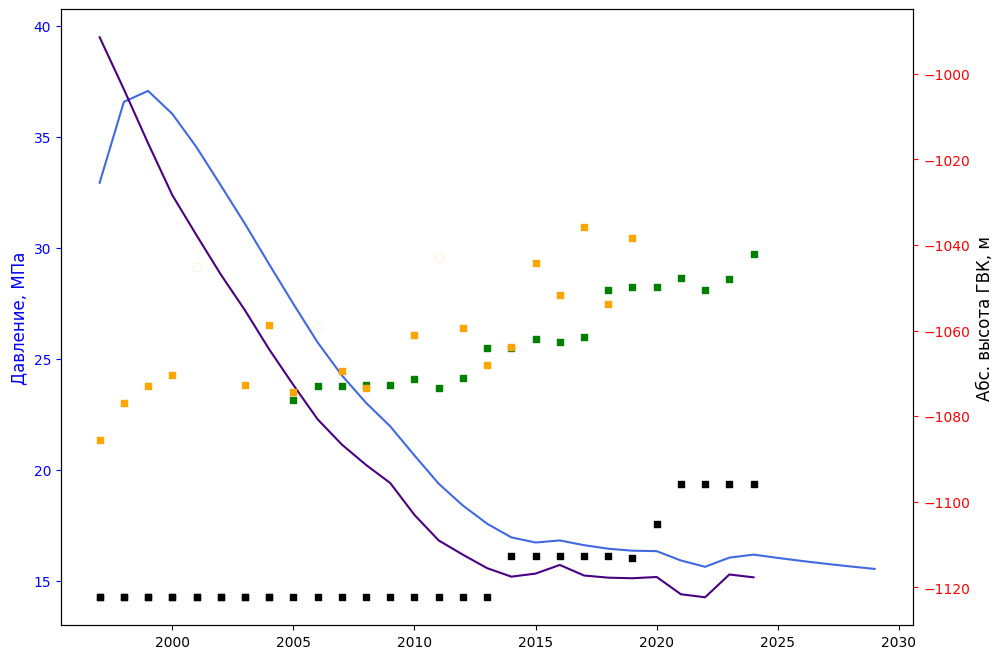

In [12]:
best_rmse_arima_list = []
best_rmse_elastic_list = []
for name in UKPG_names:
    if name not in ['УКПГ2', 'УКПГ5']:
        print(name)
        plot_data_biba, rmse_elastic = predict_UKPG_elastic(name)
        best_rmse_elastic_list.append(rmse_elastic)

        plot_data_biba, best_rmse_arima = predict_UKPG_arima(name)
        best_rmse_arima_list.append(best_rmse_arima)
        
        # # Объединяем all_perforations с plot_data для получения прогноза ГВК
        # all_perforations = all_perforations.merge(
        #     plot_data[['Год', 'Участок', 'ГВК_прогноз_arima']],
        #     left_on=['Year', 'Area'],
        #     right_on=['Год', 'Участок'],
        #     how='left',
        #     suffixes=('', '_x')  # Добавляем суффикс только для дублирующихся колонок справа
        # )

        # all_perforations['is_water'] = all_perforations['ГВК_прогноз_arima'] > all_perforations['Перфорация']

        # water_counts = all_perforations.groupby(['Year', 'Area'])['is_water'].sum().reset_index()
        # plot_data = plot_data.merge(
        #     water_counts.rename(columns={'is_water': 'Кол-во обводненных скв'}),
        #     left_on=['Год', 'Участок'],
        #     right_on=['Year', 'Area'],
        #     how='left'
        # )

        plot_UKPG(name)

        
print(f'Среднее RMSE ARIMA: {np.mean(best_rmse_arima_list):.2f}')
print(f'Среднее RMSE ElasticNet: {np.mean(best_rmse_elastic_list):.2f}')

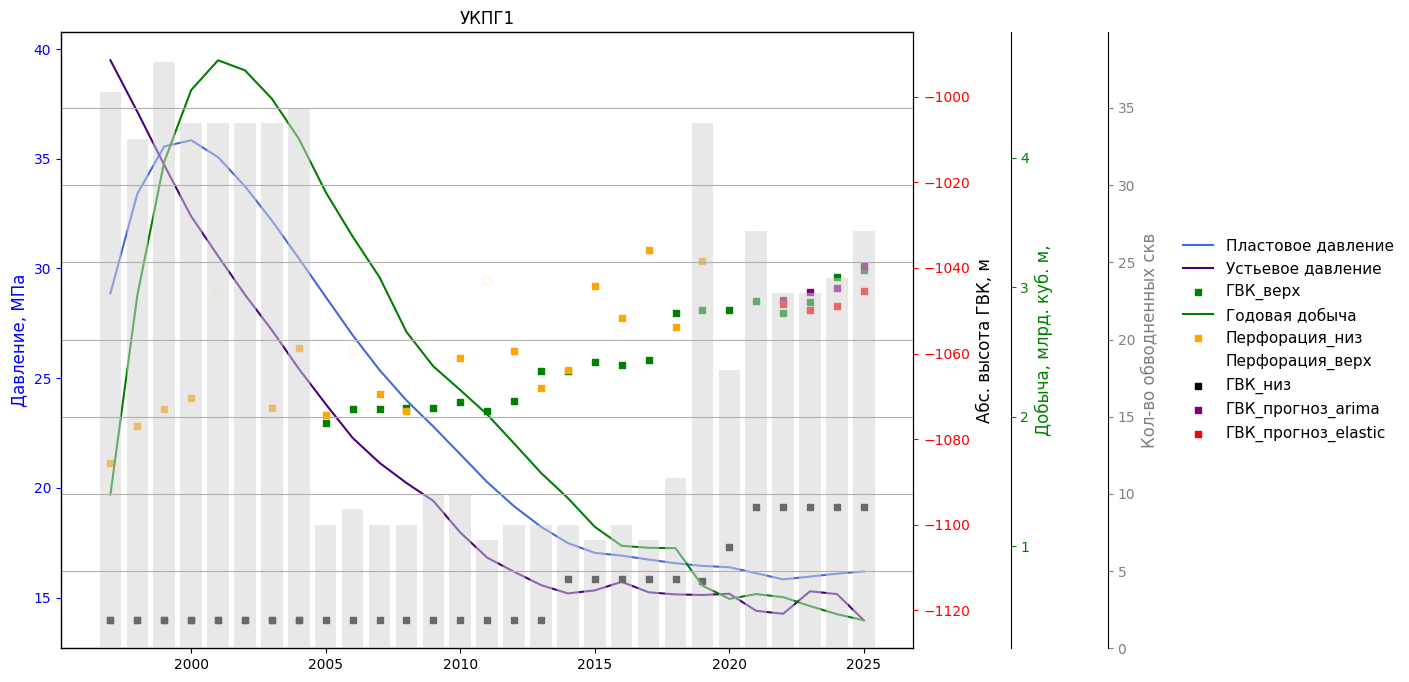

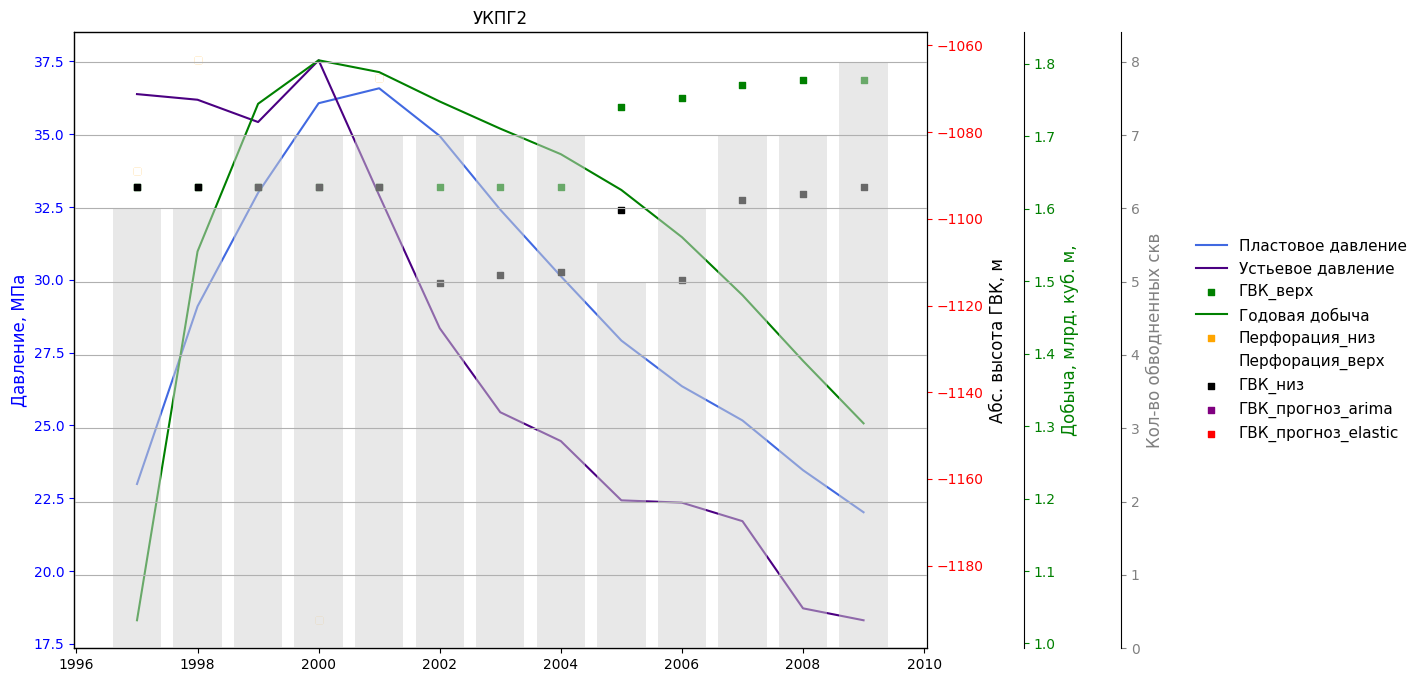

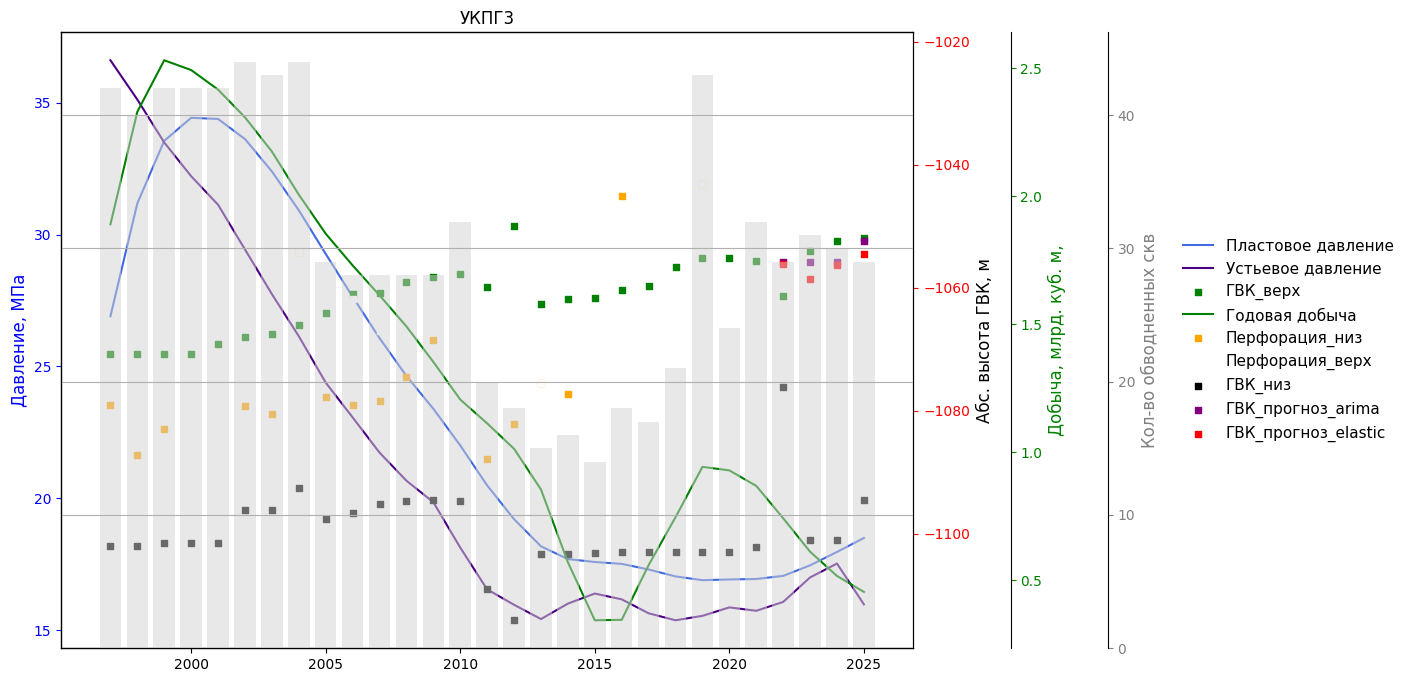

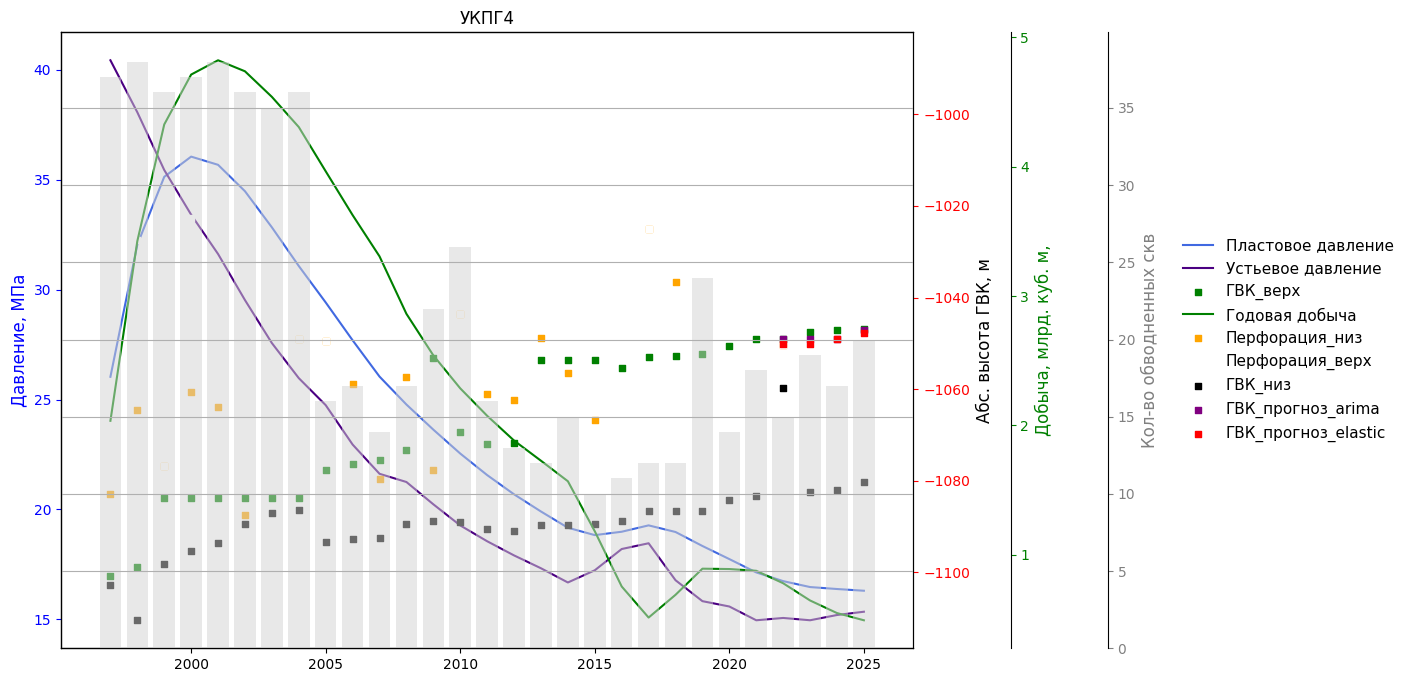

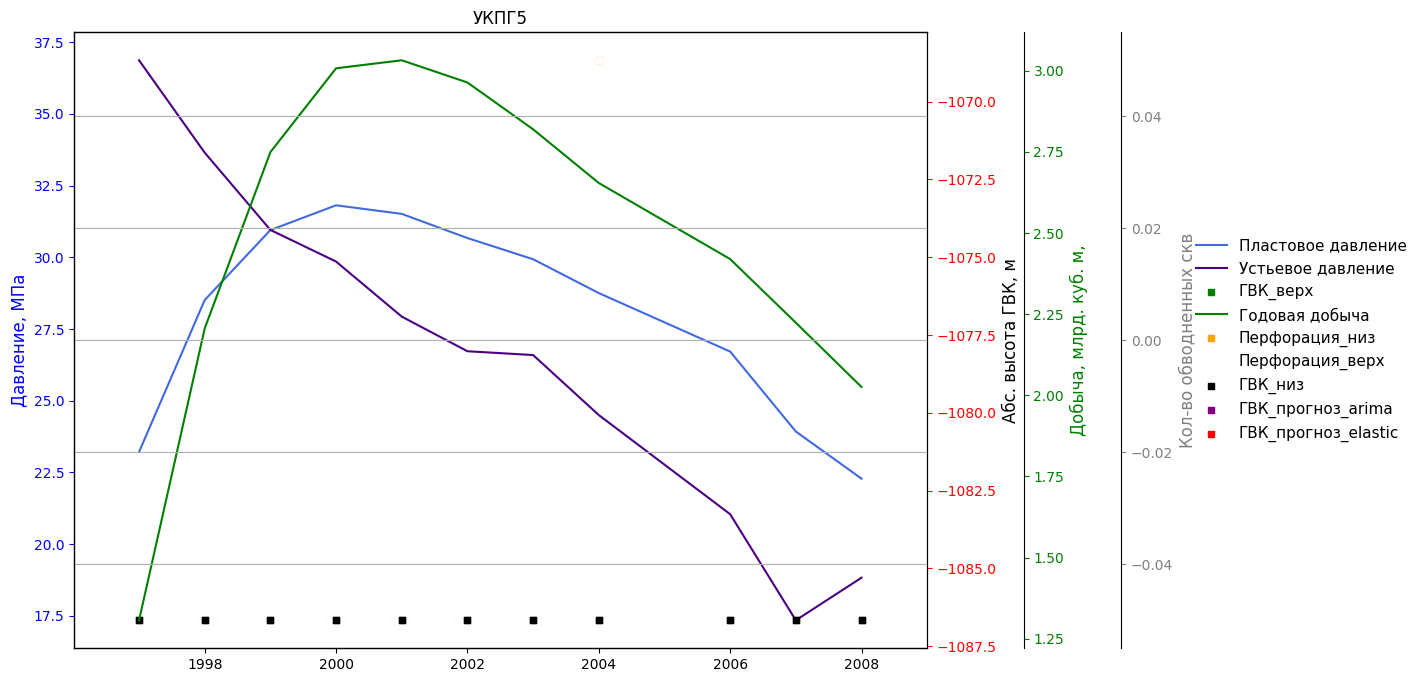

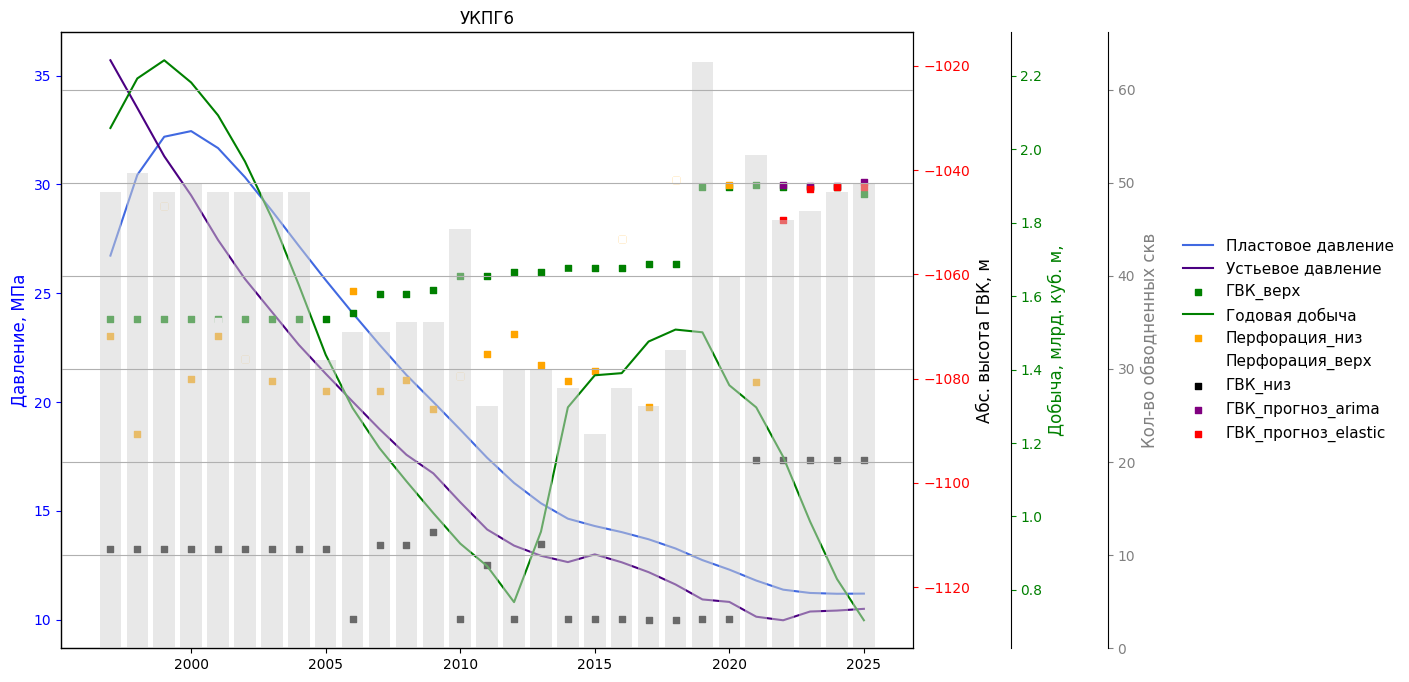

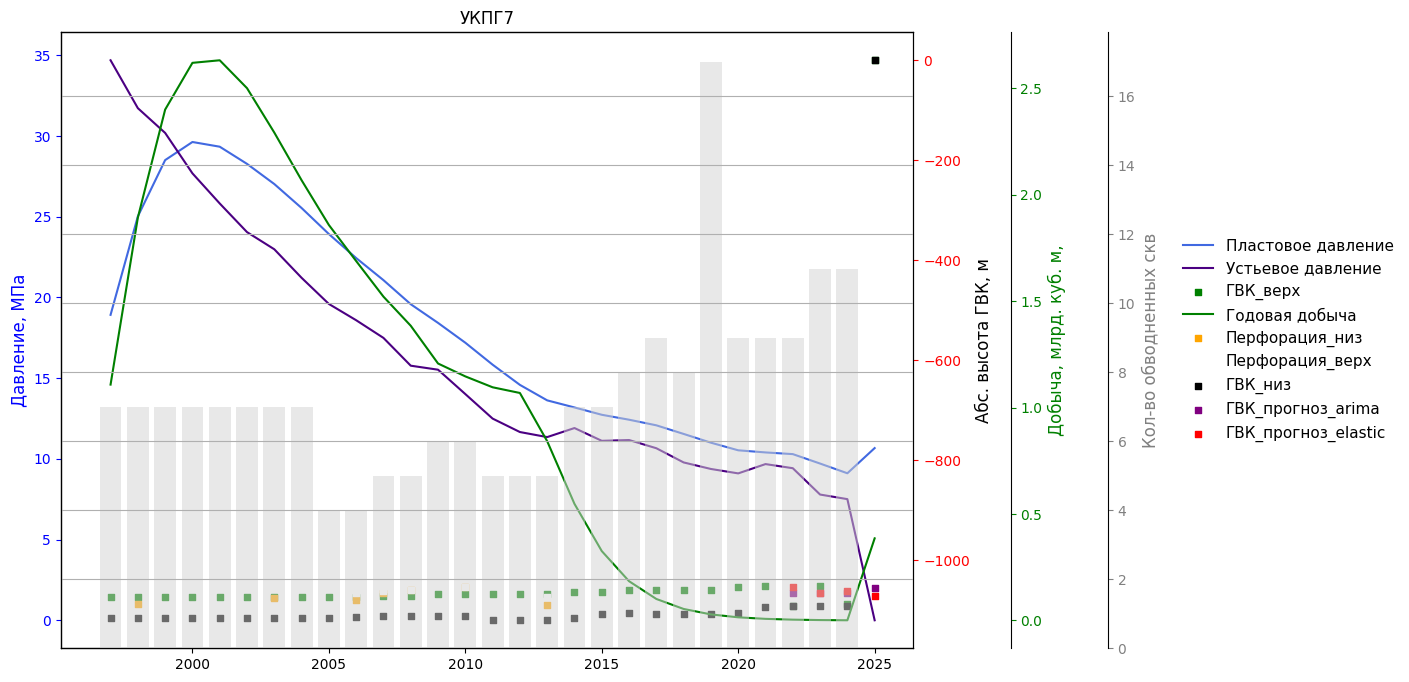

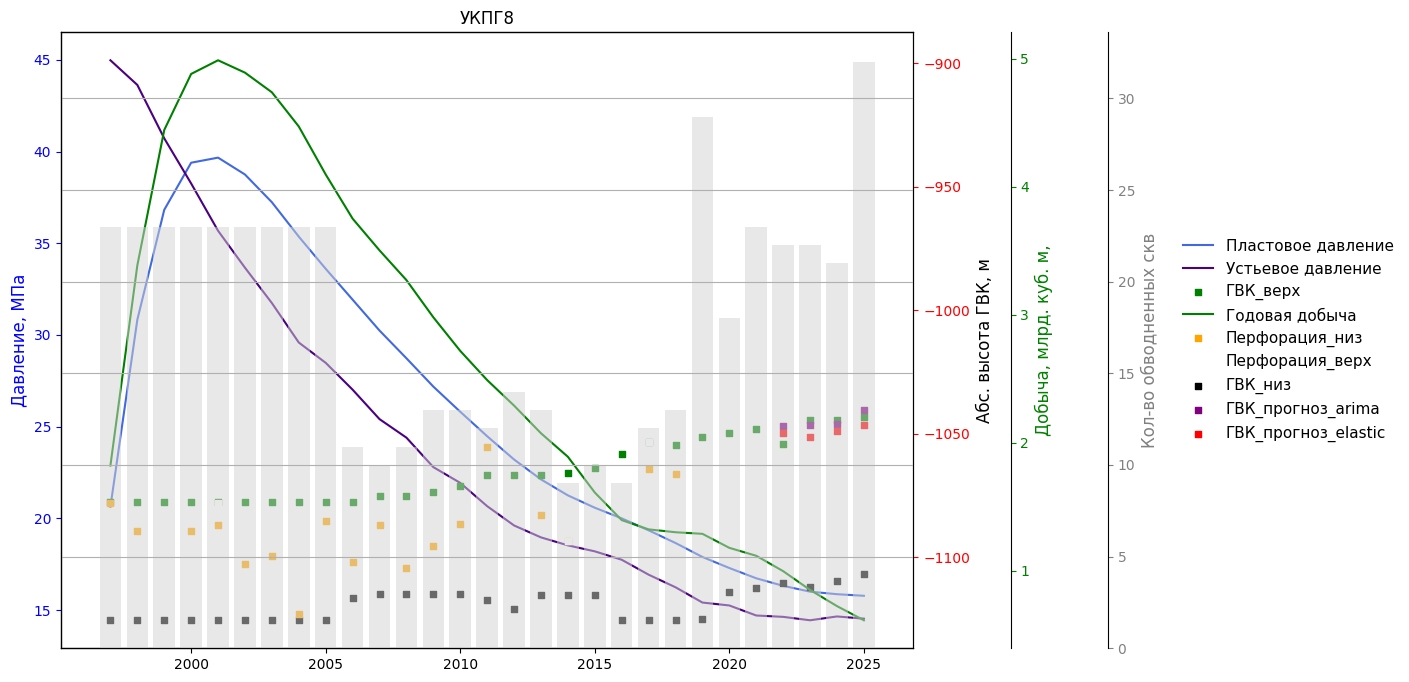

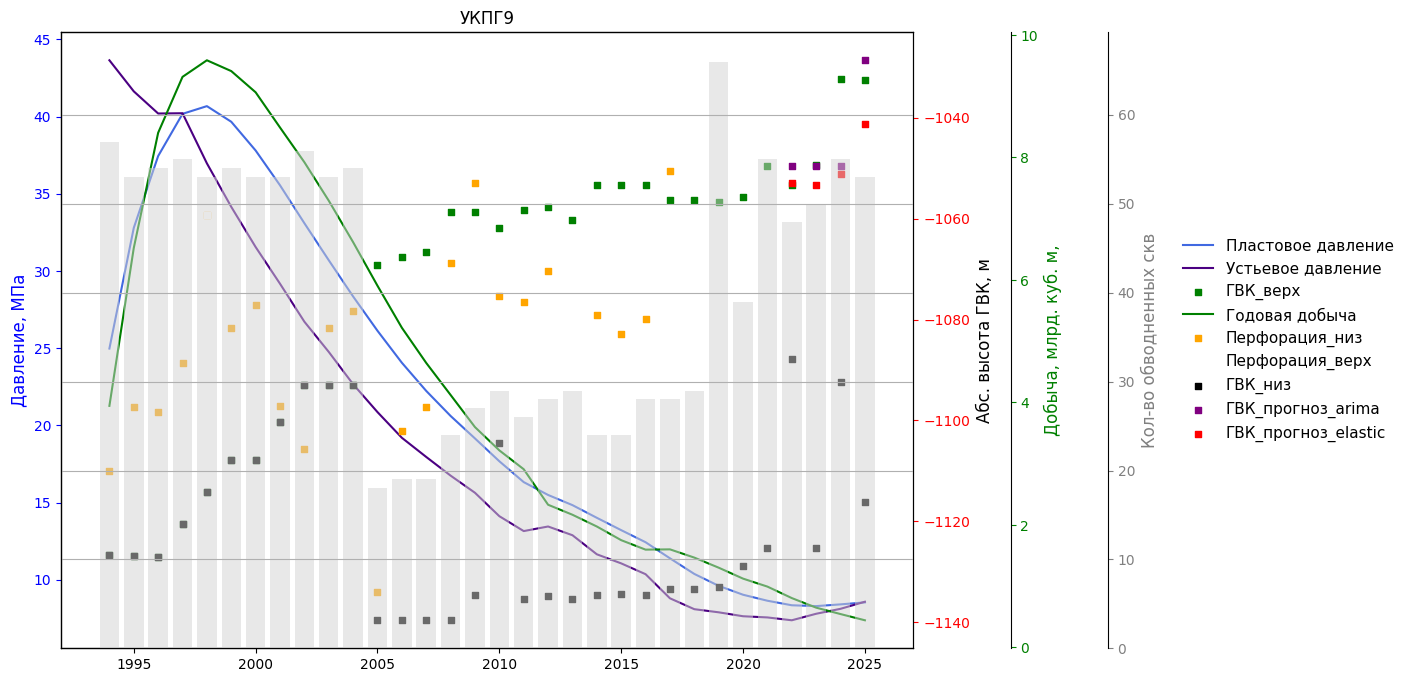

In [39]:
def plot_UKPG_fake(UKPG_name):

    plot_data_UKPG = plot_data[(plot_data['Участок'] == UKPG_name) & (plot_data['Год'] <= 2025)]
 
    X = plot_data_UKPG['Год']
    X_from2022 = plot_data_UKPG[plot_data_UKPG['Год'] >= 2022]['Год']
    Y1_1 = plot_data_UKPG['Давление']
    Y1_2 = plot_data_UKPG['Р_устье']
    Y3 = plot_data_UKPG['Добыча_год']
    Y2_1 = plot_data_UKPG['ГВК_верх']
    Y2_2 = plot_data_UKPG['ГВК_низ']
    Y2_3 = plot_data_UKPG['Перфорация_низ']
    Y2_4 = plot_data_UKPG['Перфорация_верх']
    Y4_1 = plot_data_UKPG['Кол-во обводненных скв']
    Y2_5 = plot_data_UKPG['ГВК_прогноз_arima']
    Y2_6 = plot_data_UKPG[plot_data_UKPG['Год'] >= 2022]['ГВК_прогноз_elastic']

    # Первая ось Y – Давления
    fig, ax1 = plt.subplots(figsize=(11, 8))
    scatter1 = ax1.plot(X, Y1_1, color='royalblue', label='Пластовое давление')
    scatter2 = ax1.plot(X, Y1_2, color='indigo', label='Устьевое давление')
    ax1.set_ylabel('Давление, МПа', color='blue', fontsize=12)
    ax1.tick_params(axis='y', colors='blue')

    # Вторая ось Y – ГВК
    ax2 = ax1.twinx()
    scatter3 = ax2.scatter(X, Y2_1, color='green', s=20, marker='s', label='ГВК_верх')
    scatter7 = ax2.scatter(X, Y2_2, color='black', s=20, marker='s', label='ГВК_низ')
    ax2.set_ylabel('Абс. высота ГВК, м', color='black', fontsize=12)
    ax2.tick_params(axis='y', colors='red')
    scatter5 = ax2.scatter(X, Y2_3, color='orange', s=20, marker='s', label='Перфорация_низ')
    scatter6 = ax2.scatter(X, Y2_4, color='white', s=20, marker='s', label='Перфорация_верх')
    scatter8 = ax2.scatter(X, Y2_5, color='purple', s=20, marker='s', label='ГВК_прогноз_arima')
    scatter9 = ax2.scatter(X_from2022, Y2_6, color='red', s=20, marker='s', label='ГВК_прогноз_elastic')
    
    
    # Третья ось Y – Годовая добыча
    ax3 = ax1.twinx()
    scatter4 = ax3.plot(X, Y3, color='green', label='Годовая добыча')
    ax3.set_ylabel('Добыча, млрд. куб. м,', color='green', fontsize=12)
    ax3.tick_params(axis='y', colors='green')
    ax3.spines['right'].set_position(('outward', 70))

    # Четвертая ось Y – Гистограмма обводненных скважин
    ax4 = ax1.twinx()
    bars = ax4.bar(X, Y4_1, color='lightgray', alpha=0.5, width=0.8, label='Обводненные скважины')
    ax4.set_ylabel('Кол-во обводненных скв', color='gray', fontsize=12)
    ax4.tick_params(axis='y', colors='gray')
    ax4.spines['right'].set_position(('outward', 140))  # Сдвигаем ось еще правее


    # Преобразуем scatter1, scatter2 и scatter4 из списков в объекты линий
    scatter1 = scatter1[0]  
    scatter2 = scatter2[0]
    scatter4 = scatter4[0]


    # Объединяем все легенды
    lines = [scatter1, scatter2, scatter3, scatter4, scatter5, scatter6, scatter7, scatter8, scatter9]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels,
              loc='center left',
              bbox_to_anchor=(1.30, 0.5),
              frameon=False, 
              fontsize=11)

    plt.title(UKPG_name)
    plt.xlabel("Год")
    plt.grid(True)
    # plt.savefig(f'график_{UKPG_name}.png', bbox_inches='tight', dpi=300)
    plt.show()


for name in UKPG_names:
  plot_UKPG_fake(name)